In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import random
import cv2
import os
import tensorflow as tf
from tqdm import tqdm

In [ ]:
good_frames = 'C:/Users/Mugil/Downloads/imgdataset/sharp'
bad_frames = 'C:/Users/Mugil/Downloads/imgdataset/defocused_blurred'

In [3]:
clean_frames = []
for file in tqdm(sorted(os.listdir(good_frames))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(good_frames + '/' + file, target_size=(128,128))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
        clean_frames.append(image)

clean_frames = np.array(clean_frames)
blurry_frames = []
for file in tqdm(sorted(os.listdir(bad_frames))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(bad_frames + '/' + file, target_size=(128,128))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
        blurry_frames.append(image)

blurry_frames = np.array(blurry_frames)

100%|██████████| 350/350 [00:05<00:00, 58.96it/s]


In [5]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K

seed = 21
random.seed = seed
np.random.seed = seed

In [6]:
x = clean_frames;
y = blurry_frames;
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
print(x_train[0].shape)
print(y_train[0].shape)

(128, 128, 3)
(128, 128, 3)


183


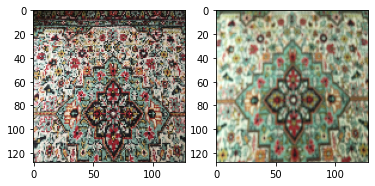

In [8]:
r = random.randint(0, len(clean_frames)-1)
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.1, wspace=0.2)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(clean_frames[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(blurry_frames[r])

In [9]:
# Network Parameters
input_shape = (128, 128, 3)
batch_size = 32
kernel_size = 3
latent_dim = 256

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

In [10]:
inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs

In [11]:
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [12]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 latent_vector (Dense)       (None, 256)               16777472  
                                                                 
Total params: 17148288 (65.42 MB)
Trainable params: 1714828

In [13]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

In [14]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 65536)             16842752  
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 256)       590080    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 64, 64, 128)       295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 128, 128, 64)      7379

In [15]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder (Functional)        (None, 256)               17148288  
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       17803395  
                                                                 
Total params: 34951683 (133.33 MB)
Trainable params: 34951683 (133.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
autoencoder.compile(loss='mse', optimizer='adam',metrics=["acc"])


In [17]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

In [18]:
callbacks = [lr_reducer]
history = autoencoder.fit(blurry_frames,
                      clean_frames,
                      validation_data=(blurry_frames, clean_frames),
                      epochs=100,
                      batch_size=batch_size,
                      callbacks=callbacks)

Epoch 1/100
9/9 [==============================] - 26s 3s/step - loss: 0.0699 - acc: 0.6176 - val_loss: 0.0688 - val_acc: 0.6688 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 21s 2s/step - loss: 0.0679 - acc: 0.6688 - val_loss: 0.0651 - val_acc: 0.6688 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 21s 2s/step - loss: 0.0648 - acc: 0.6342 - val_loss: 0.0592 - val_acc: 0.4694 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 21s 2s/step - loss: 0.0599 - acc: 0.5967 - val_loss: 0.0546 - val_acc: 0.6688 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 21s 2s/step - loss: 0.0539 - acc: 0.6675 - val_loss: 0.0517 - val_acc: 0.6615 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 21s 2s/step - loss: 0.0484 - acc: 0.5997 - val_loss: 0.0454 - val_acc: 0.6591 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 23s 3s/step - loss: 0.0450 - acc: 0.6668 - val_loss: 0.0440 - val_acc: 0.6687 - lr: 0.0010
Epoch 


       Input                        Ground Truth                  Predicted Value
1/1 [==============================] - 0s 69ms/step


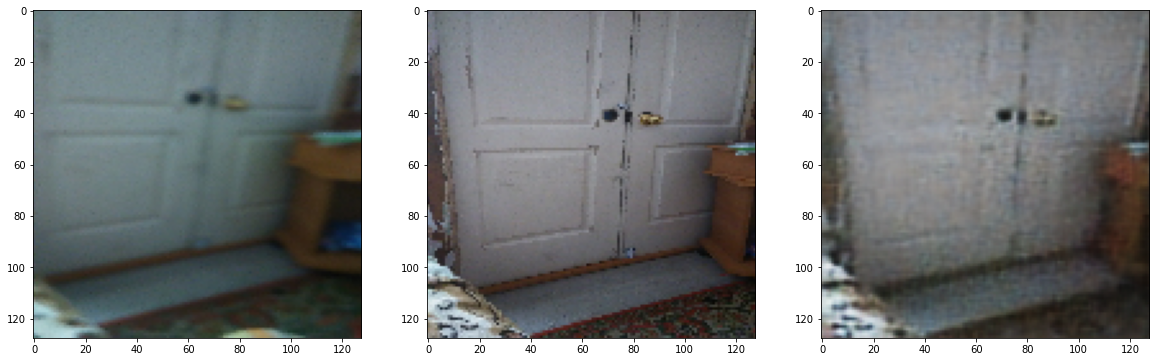

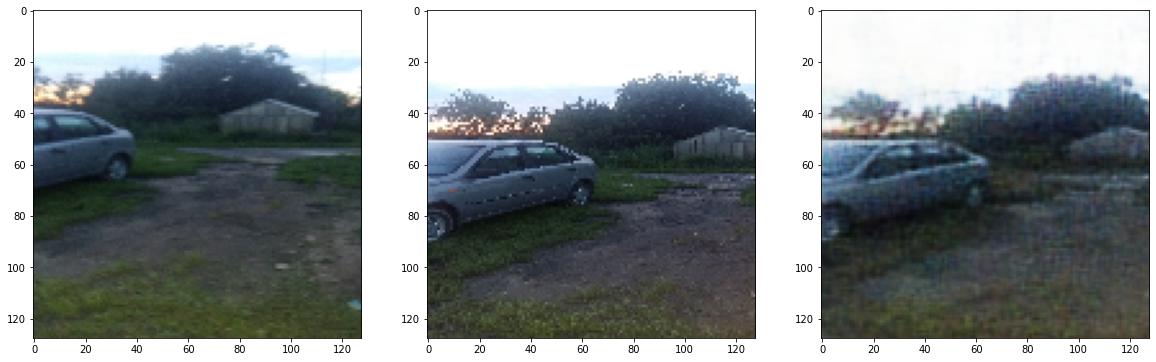

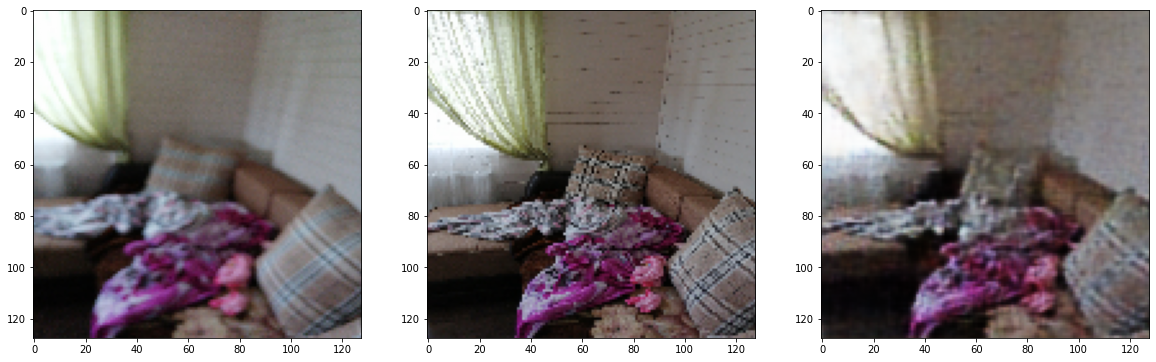

In [20]:
print("\n       Input                        Ground Truth                  Predicted Value")
for i in range(3):
    
    r = random.randint(0, len(clean_frames)-1)

    x, y = blurry_frames[r],clean_frames[r]
    x_inp=x.reshape(1,128,128,3)
    result = autoencoder.predict(x_inp)
    result = result.reshape(128,128,3)

    fig = plt.figure(figsize=(20,18))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(result)


       Input                        Ground Truth                  Predicted Value                PSNR
1/1 [==============================] - 0s 83ms/step


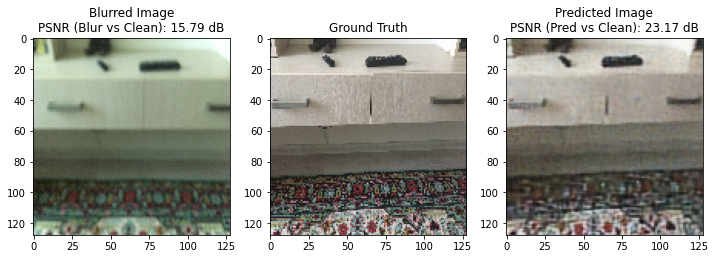

1/1 [==============================] - 0s 61ms/step


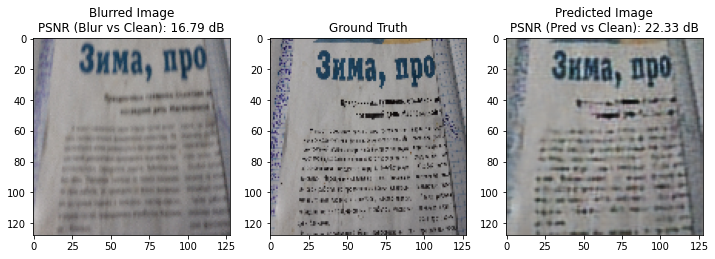

1/1 [==============================] - 0s 83ms/step


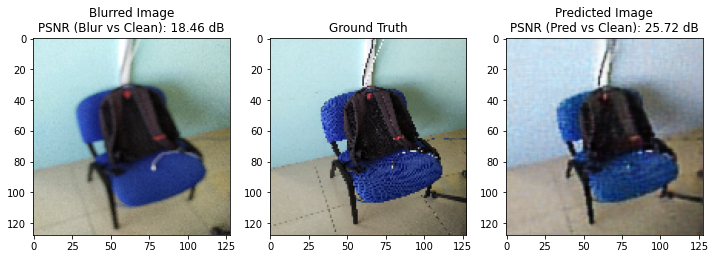

In [21]:
from sklearn.metrics import mean_squared_error
import numpy as np

def psnr(original, compared):
    mse = np.mean((original - compared) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
        return 100
    max_pixel = 1.0  # Since the images are normalized to range [0, 1]
    psnr_value = 10 * np.log10(max_pixel ** 2 / mse)
    return psnr_value

print("\n       Input                        Ground Truth                  Predicted Value                PSNR")
for i in range(3):
    r = random.randint(0, len(clean_frames)-1)

    x, y = blurry_frames[r], clean_frames[r]
    x_inp = x.reshape(1,128,128,3)
    
    # Get the predicted image
    result = autoencoder.predict(x_inp)
    result = result.reshape(128,128,3)
    
    # Calculate PSNR between clean and predicted, and clean and blurred
    psnr_blur_vs_clean = psnr(y, x)      # Blurred vs Clean image
    psnr_pred_vs_clean = psnr(y, result) # Predicted vs Clean image
    
    fig = plt.figure(figsize=(12,10))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)
    ax.set_title(f"Blurred Image\nPSNR (Blur vs Clean): {psnr_blur_vs_clean:.2f} dB")

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)
    ax.set_title("Ground Truth")

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(result)
    ax.set_title(f"Predicted Image\nPSNR (Pred vs Clean): {psnr_pred_vs_clean:.2f} dB")

    plt.show()
